In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def str2complex(s):
    str = s.replace(" ","").replace("i","j")
    return complex(str)

In [5]:
def Plot_Profile(F,type='Abs',figsize=(3,2),fontsize=5):
    plt.figure(figsize=figsize)
    plt.rcParams.update({'font.size': fontsize})
    if type =='Re':
        plt.imshow(np.real(F))
    elif type =='Im':
        plt.imshow(np.imag(F))
    else:
        plt.imshow(np.abs(F))
    plt.colorbar()
    plt.show()

In [6]:
filename = './ModeProfile/Mode2_Ey.txt'
Field = np.array([[]])
with open(filename) as f:
    lines = f.readlines()
    Field = np.array([str2complex(s) for s in lines[0].split('\t')])
    for line in lines[1:]:
        line_arr = line.split('\t')
        Field = np.c_[Field,np.array([str2complex(s) for s in line_arr])]

print("# of lines:",len(lines))
print("# of columns:",len(lines[0].split('\t')))
print("shape of Field matrix:",np.shape(Field))

# of lines: 223
# of columns: 223
shape of Field matrix: (223, 223)


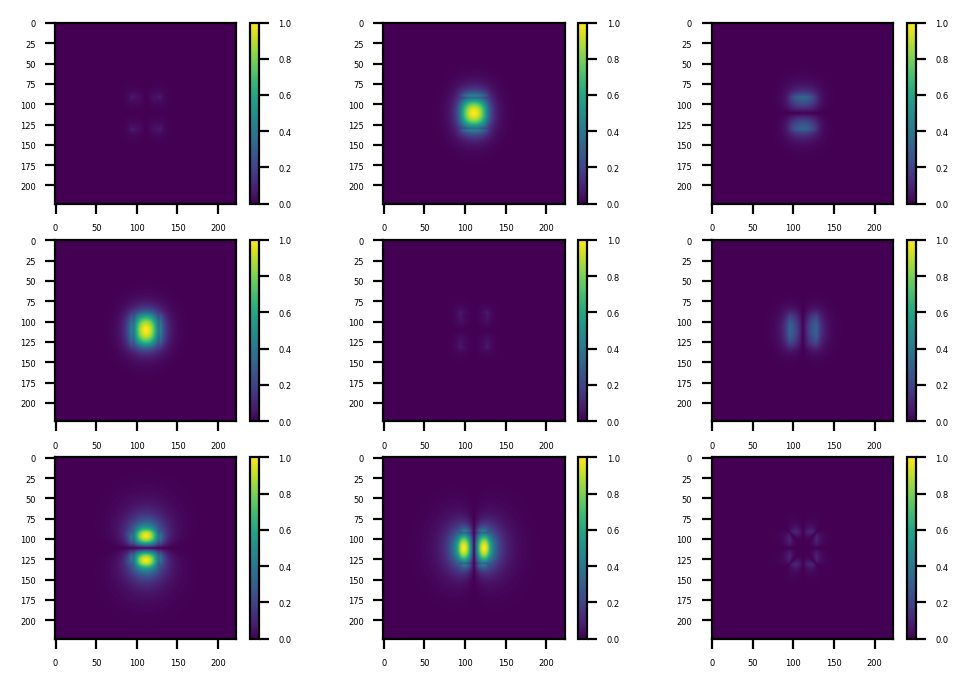

In [7]:
plt.figure(figsize=(6,4),dpi=200)
plt.rcParams.update({'font.size': 3})
MaxModeNum=3
for i in range(MaxModeNum):
    for j in range(3):
        component_list = ['Ex','Ey','Ez']
        filename = './ModeProfile/Mode'+str(i+1)+'_'+component_list[j]+'.txt'
        Field = np.array([[]])
        with open(filename) as f:
            lines = f.readlines()
            Field = np.array([str2complex(s) for s in lines[0].split('\t')])
            for line in lines[1:]:
                line_arr = line.split('\t')
                Field = np.c_[Field,np.array([str2complex(s) for s in line_arr])]
        plt.subplot(MaxModeNum,3,i*3+j+1)
        plt.imshow(np.abs(Field),vmin=0, vmax=1)
        plt.colorbar()


plt.show()

In [8]:
#length:        length of the device in that direction. E.g.: For X axis, length = a
#kMax:          to obtain physical solutions
#NumOfPoints:   Num of sample points of X
#Drift:         to avoid the singular points of Tan(x)
def find_zero(func,length,kMax,m=1,NumOfPoints = 100,Drift = 5e-3):

    #X in one single period of Tan(x)
    X = np.linspace((-np.pi/2 + (m-1)*np.pi/2 + Drift)/length,
                    (np.pi/2 + (m-1)*np.pi/2 - Drift)/length, NumOfPoints)
    X = X[X>0]
    X = X[X<kMax]
    Y = func(X,m)
    res = np.array([])
    found = False
    for i in range(len(Y)-1):
        if found:
            found = False
            continue
        if Y[i] * Y[i+1] <= 0:
            found = True
            if Y[i] * Y[i+1] < 0:
                res = np.append(res,(X[i]+X[i+1])/2)
            elif Y[i] == 0:
                res = np.append(res,X[i])
            else:
                res = np.append(res,X[i+1])
    return res

def Plot_func(func,length,kMax,m=1,NumOfPoints = 100,Drift = 5e-3):
    X = np.linspace((-np.pi/2 + (m-1)*np.pi/2 + Drift)/length,
                    (np.pi/2 + (m-1)*np.pi/2 - Drift)/length, NumOfPoints)
    X = X[X>0]
    X = X[X<kMax]
    Y = func(X,m)
    return X,Y

In [9]:
'''
Marcatili Method

Known Parameters:
n1      :   refractive index of the waveguide
n0      :   refractive index of the cladding
a       :   width of the waveguide in the x direction
b       :   thickness ofthe waveguide in the y direction
lambda0 :   wavelength in vacuum

Unknown Variables:
kx, ky, kx2, ky2, beta

kx^2 + ky^2 + beta^2      = k0^2 * n1^2                                       region  1
-kx^2 + ky2^2 + beta^2    = k0^2 * n0^2                                       region  2
kx^2 - ky2^2 + beta^2     = k0^2 * n0^2                                       region  3
kx2 * n1^2 / (kx * n0^2)  = tan(kx * a - m * pi / 2)                boundary condition x
ky2 / ky                  = tan(ky * b - n * pi / 2)                boundary condition y
'''
#n1      =   3.47638
n1      =   1.99
n0      =   1.4585
a       =   1e-6
b       =   1e-6
lambda0 =   1550e-9
k0      =   2 * np.pi / lambda0
# k0      =   2.3

# m:order
def func_kx(kx,m):
    len = np.shape(kx)[0]
    assert n1 > n0
    assert np.all(np.ones(len) * k0**2*(n1**2-n0**2) > kx**2)
    return kx * np.tan(kx * a - (m-1) * np.pi / 2) - \
            np.sqrt(k0**2*(n1**2-n0**2) - kx**2) * (n1/n0)**2

def func_ky(ky,m):
    len = np.shape(ky)[0]
    assert n1 > n0
    assert np.all(np.ones(len) * k0**2*(n1**2-n0**2) > ky**2)
    return ky * np.tan(ky * b - (m-1) * np.pi / 2) - \
            np.sqrt(k0**2*(n1**2-n0**2) - ky**2)


In [10]:
'''
Kumar Method

Known Parameters:
n1      :   refractive index of the waveguide
n0      :   refractive index of the cladding
a       :   width of the waveguide in the x direction
b       :   thickness ofthe waveguide in the y direction
lambda0 :   wavelength in vacuum

Unknown Variables:
kx, ky, kx2, ky2, beta_x, beta_y

E(x,y) = X(x)Y(y)
beta^2 = beta_x^2+beta_y^2
N(x,y) = n(x,y_^2 = n(x)^2 + n(y)^2

kx^2 + beta_x^2    = k0^2 * (nx(x)^2) = k0^2 * n1^2 /2            x<a
-kx2^2 + beta_x^2  = k0^2 * (nx(x)^2) = k0^2 * (n0^2-n1^2 /2)     x>a
=> kx^2 + kx2^2    = k0^2 * (n1^2-n0^2)

ky^2 + beta_y^2    = k0^2 * (ny(y)^2) = k0^2 * n1^2 /2            y<b
-ky2^2 + beta_y^2  = k0^2 * (ny(y)^2) = k0^2 * (n0^2-n1^2 /2)     y>b
=> ky^2 + ky2^2    = k0^2 * (n1^2-n0^2)

kx2 * n1^2 / (kx * n0^2)  = tan(kx * a - m * pi / 2)                boundary condition x
ky2 / ky                  = tan(ky * b - n * pi / 2)                boundary condition y
'''
#n1      =   3.47638
n1      =   1.2
n0      =   1.0
a       =   1e-6
b       =   1e-6
lambda0 =   1550e-9
k0      =   2*np.pi/lambda0
# k0      =   2.3

# m:order
def func_kx(kx,m):
    len = np.shape(kx)[0]
    assert n1 > n0
    assert np.all(np.ones(len) * k0**2*(n1**2-n0**2) > kx**2)
    return kx * np.tan(kx * a - (m-1) * np.pi / 2) - \
            np.sqrt(k0**2*(n1**2-n0**2) - kx**2) * (n1/n0)**2

def func_ky(ky,m):
    len = np.shape(ky)[0]
    assert n1 > n0
    assert np.all(np.ones(len) * k0**2*(n1**2-n0**2) > ky**2)
    return ky * np.tan(ky * b - (m-1) * np.pi / 2) - \
            np.sqrt(k0**2*(n1**2-n0**2) - ky**2)


In [11]:
np.sqrt(2*n0**2-n1**2)

np.float64(0.7483314773547883)

In [12]:
k0**2*(n1**2-n0**2)*a**2

7.230178458238196

In [13]:
def plot_aux():
    kx_max = np.sqrt(k0**2*(n1**2-n0**2))*0.999
    Threshold   =   1e-2

    X   = np.linspace(0,kx_max,1000)
    Discontinuity_Idx_0 = np.where((X - np.pi*0.5) % np.pi < Threshold)
    Y_0 = func_kx(X,0)
    Y_2 = func_kx(X,2)
    Y_0[Discontinuity_Idx_0] = np.nan
    Y_2[Discontinuity_Idx_0] = np.nan

    Discontinuity_Idx_1 = np.where(X % np.pi < Threshold)
    Y_1 = func_kx(X,1)
    Y_1[Discontinuity_Idx_1] = np.nan

    plt.figure(figsize=(3,2),dpi=100)
    plt.plot(X,Y_0)
    plt.plot(X,Y_1)
    plt.plot(X,Y_2)
    plt.ylim((-100, 100))
    plt.plot(X,np.zeros(1000))

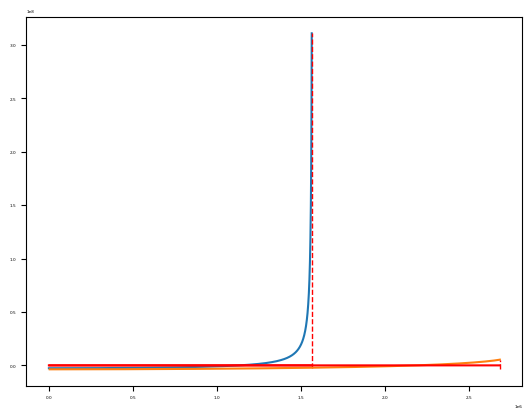

In [14]:
NumOfPointsX = 10000
NumOfPointsY = 100
ky_max = np.sqrt(k0**2*(n1**2-n0**2))*0.999
for m in range(1,3):
    Xm,Ym = Plot_func(func_ky,kMax=ky_max,length=a,m=m,Drift=5e-3,NumOfPoints=NumOfPointsX)
    plt.plot(Xm,Ym)
    plt.plot(Xm,np.ones(len(Xm)),color='r')
    plt.plot(np.ones(NumOfPointsY)*np.max(Xm),
             np.linspace(np.min(Ym),np.max(Ym),NumOfPointsY)
             ,color='r',linewidth=1,linestyle='dashed')

plt.show()

In [15]:
m = 1
kx_max = np.sqrt(k0**2*(n1**2-n0**2))*0.999
kx_roots = find_zero(func_kx,a,kx_max,m=m,NumOfPoints=int(1e7),Drift=1e-3)
assert len(kx_roots)>0
kx = kx_roots[0]
kx2 = np.sqrt(k0**2*(n1**2-n0**2) - kx**2)
print("kx = %.2f, kx2 = %.2f"%(kx,kx2))

kx = 1228261.20, kx2 = 2391976.77


In [16]:
n = 1
ky_max = np.sqrt(k0**2*(n1**2-n0**2))*0.999
ky_roots = find_zero(func_ky,b,ky_max,m=n,NumOfPoints=int(1e7),Drift=1e-3)
assert len(ky_roots)>0
ky = ky_roots[0]
ky2 = np.sqrt(k0**2*(n1**2-n0**2) - ky**2)
print("ky = %.2f, ky2 = %.2f"%(ky,ky2))

ky = 1135020.94, ky2 = 2437602.49


In [17]:
#Beta_0^2 = k0^2 * n1^2 - (kx^2 + ky^2)
beta_0_squared = k0**2 * n1**2 - kx**2 - ky**2
beta_0 = np.sqrt(beta_0_squared)
beta_0 / k0
print("neff = %.10f"%(beta_0/k0))

neff = 1.1268504196


In [18]:
# Perturbation Theory
# beta^2 = beta_0^2 + beta_1^2

Int_a_Inf_x = (np.cos(kx * a + (m-1)*np.pi/2))**2
Int_b_Inf_y = (np.cos(ky * b + (n-1)*np.pi/2))**2
Int_0_Inf_x = (kx2 * a + np.sin(2*kx*a + (m-1)*np.pi) * kx2/(2*kx) + Int_a_Inf_x)
Int_0_Inf_y = (ky2 * b + np.sin(2*ky*b + (n-1)*np.pi) * ky2/(2*ky) + Int_b_Inf_y)
beta_1_squared = k0**2*(n1**2-n0**2) * Int_a_Inf_x * Int_b_Inf_y / (Int_0_Inf_x * Int_0_Inf_y)

beta = np.sqrt(beta_0_squared + beta_1_squared)
#beta / k0
print("beta1^2 = ",beta_1_squared)
print("beta0^2 = ",beta_0_squared)
print("neff = %.10f"%(beta/k0))

beta1^2 =  13546623822.946703
beta0^2 =  20865504116490.42
neff = 1.1272161558


In [19]:
#For TE modes: Nonzero components are (Ey, Ez);(Hx, Hz). HF = Hx
#For TM modes: Nonzero components are (Ex, Ez);(Hy, Hz). HF = Hy
def HFieldProfile(x,y,A=1):

    X = np.zeros(np.shape(x))
    Y = np.zeros(np.shape(y))

    for line_idx in range(np.shape(X)[0]):
        Xline = X[line_idx]
        xline = x[line_idx]
        Xline[np.logical_and(xline>=-a,xline<=a)] = \
                    np.cos(kx * xline)[np.logical_and(xline>=-a,xline<=a)]
        Xline[xline>a] = np.cos(kx * a) * np.exp(-kx2 * (xline-a))[xline>a]
        Xline[xline<-a] = np.cos(kx * a) * np.exp(kx2 * (xline+a))[xline<-a]

    for line_idx in range(np.shape(Y)[0]):
        Yline = Y[line_idx]
        yline = y[line_idx]
        Yline[np.logical_and(yline>=-a,yline<=a)] = \
                    np.cos(ky * yline)[np.logical_and(yline>=-a,yline<=a)]
        Yline[yline>a] = np.cos(ky * a) * np.exp(-kx2 * (yline-a))[yline>a]
        Yline[yline<-a] = np.cos(ky * a) * np.exp(kx2 * (yline+a))[yline<-a]

    HF = X * Y
    return HF

In [44]:
#d Hy/ dy + d Hz/ dz = 0;     Hz = -i / beta * (d Hy /dy)

def Hz_Profile(HF,Y,beta):
    Hz = np.zeros(np.shape(HF),dtype=np.complex64)

    for i in range(np.shape(HF)[1]-1):
        Hz[:,i] = -1 / beta * (HF[:,i+1]-HF[:,i])/(Y[:,i+1]-Y[:,i])

    return Hz

#For TE modes, Ez = 1/(2*pi*f*n^2)*(d Hx/ dy)
#For TM modes, Ez = -1/(2*pi*f*n^2)*(d Hy/ dx)
#N = n(x,y)^2
def Ez_Profile(HF,N,X,Y,Polarizarion='TE'):
    Ez = np.zeros(np.shape(HF))
    if not Polarizarion == 'TE':
        for i in range(np.shape(HF)[0]-1):
            Ez[i,:] = -1* np.reciprocal(N[i,:]) * (HF[i+1,:]-HF[i,:])/(X[i+1,:]-X[i,:])
    else:
        for i in range(np.shape(HF)[1]-1):
            Ez[:,i] = -1* np.reciprocal(N[:,i]) * (HF[:,i+1]-HF[:,i])/(Y[:,i+1]-Y[:,i])
    return Ez


#EF: Component orthogonal to HF
#For TE modes, EF = Ey      Ey =  i / (2pi*f*n^2) * (d Hz /dx - d Hx /dz)
#For TM modes, EF = Ex;     Ex = -i / (2pi*f*n^2) * (d Hz /dy - d Hy /dz)

# d Hy /dz = -i* beta * Hy
def EF_Profile(HF,Hz,X,Y,beta,Polarizarion='TE'):
    EF = np.zeros(np.shape(HF))
    if not Polarizarion == 'TE':
        for i in range(np.shape(HF)[1]-1):
            EF[:,i] = -1* np.reciprocal(N[:,i]) * (complex(0,1) * (Hz[:,i+1]-Hz[:,i])/(Y[:,i+1]-Y[:,i]) - beta * HF[:,i])
    else:
        for i in range(np.shape(HF)[0]-1):
            EF[i,:] = np.reciprocal(N[i,:]) * ( complex(0,1) * (Hz[i+1,:]-Hz[i,:])/(X[i+1,:]-X[i,:]) - beta * HF[i,:] )

    return EF


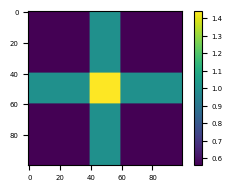

In [45]:
step = 0.1
X,Y  = np.mgrid[-a*5 : a*5 : a*step,-b*5 : b*5 : b*step]
# F    = FieldProfile(X,Y)
Nx = np.ones(np.shape(X))*n1**2/2
Nx[X<-a] = n0**2-n1**2/2
Nx[X>a]  = n0**2-n1**2/2

Ny = np.ones(np.shape(Y))*n1**2/2
Ny[Y<-b] = n0**2-n1**2/2
Ny[Y>b]  = n0**2-n1**2/2

#N(x,y): Refractive index matrix
#N(x,y) = Nx+Ny = n(x,y)_^2 = n(x)^2 + n(y)^2

N = Nx + Ny

Plot_Profile(N)



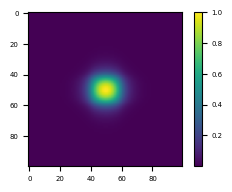

In [46]:
#For TE modes: Nonzero components are (Ey, Ez);(Hx, Hz). HF = Hx
#For TM modes: Nonzero components are (Ex, Ez);(Hy, Hz). HF = Hy
HF = HFieldProfile(X,Y)
Plot_Profile(HF)


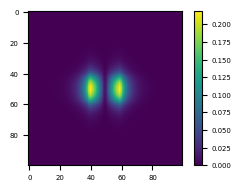

In [47]:
Hz = Hz_Profile(HF,Y,beta)
Plot_Profile(np.abs(Hz),type='Re')
#Plot_Profile(Hz,type='Im')


/var/folders/ch/7r5m10cd1x18pgpw08_ksg300000gn/T/ipykernel_50370/1765166557.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  EF[i,:] = np.reciprocal(N[i,:]) * ( complex(0,1) * (Hz[i+1,:]-Hz[i,:])/(X[i+1,:]-X[i,:]) - beta * HF[i,:] )


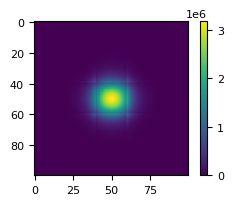

In [48]:
EF = EF_Profile(HF,Hz,X,Y,beta)
Plot_Profile(np.abs(EF),type='Re',figsize=(3,2),fontsize=8)